## Data Augmentation with DeepFake-ECG

In [60]:
import numpy as np
import h5py
import xml.etree.ElementTree as ET
import os
from torch_two_sample.statistics_diff import MMDStatistic
from HuggingProcess import ECGPreprocessor
import json
from transformers import AutoModel
from scipy.signal import resample
import matplotlib.pyplot as plt
import torch
from pulse2pulse import Pulse2pulseGenerator as Generator
import tensorflow as tf
import pandas as pd

In [17]:
# This code initializes a pre-trained AutoModel for deepfake ECG generation.
# The model is loaded from the "deepsynthbody/deepfake_ecg" repository on Hugging Face's model hub.
# trust_remote_code=True ensures that the remote code is trusted and can be executed safely.

model = AutoModel.from_pretrained("deepsynthbody/deepfake_ecg", trust_remote_code=True)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [18]:
# data = np.load("data.npy")

# derivations_to_keep = [0, 1, 6, 7, 8, 9, 10, 11]

# data_new = data[:, derivations_to_keep, :]

# print(data_new.shape) # (827, 8, 5000)

# This function reads an ECG file and extracts the pacemaker ECG data.
# Input: 
# - file_path: a string representing the path to the ECG file.
# Output:
# - pacemaker_ecg: a numpy array containing the pacemaker ECG data.

with h5py.File('./xml_data/ECG.H5', 'r') as f:
        pacemaker_ecg = f['tracings'][:]
        
pacemaker_ecg.shape

(52, 5000, 8)

In [19]:
# Transpose ECG data from pacemaker
pkt_ecg = np.transpose(pacemaker_ecg, (0, 2,1))
pkt_ecg.shape

(52, 8, 5000)

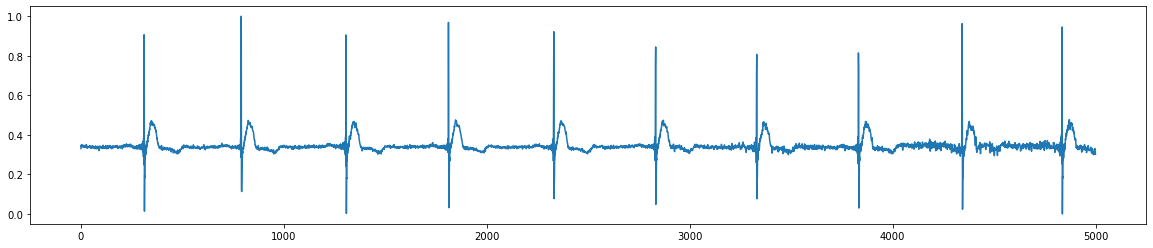

In [20]:
# This function plots an ECG signal
ecg = pkt_ecg[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(ecg);

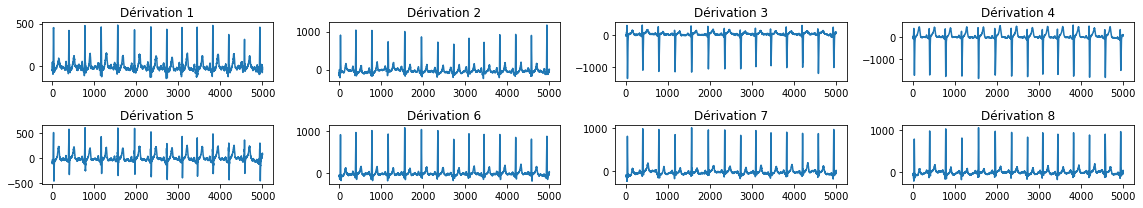

In [21]:
# This code generates a plot of the output of a model for 5 samples.
# The plot has 2 rows and 4 columns, with each subplot showing the output for one of the 8 derivations.
# The input parameter is num_samples, which specifies the number of samples to generate.
# The output parameter is a plot showing the output of the model for each derivation.

out = model(num_samples=5) # Generates output for 5 samples
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,3))

for i in range(2): # Loops through rows
    for j in range(4): # # Loops through columns
        ax[i,j].plot(out[0][:,j+(i*4)]) # Plots output for current derivation
        ax[i,j].set_title('Dérivation ' + str(j+(i*4)+1)) # Sets title for current subplot

plt.tight_layout()
plt.show()


In [22]:
# loads a pre-trained generator model and its statistics
# The generator model is used to generate synthetic data
# The function loads the model and sets it to evaluation mode

# We set the device to CPU
device = torch.device("cpu")

# We create an instance of the Generator class
netG = Generator()

# Load the pre-trained statistics of the generator model
model_gstat = torch.load('g_stat.pt', map_location=device)

#Load the state dictionary of the generator model from the loaded statistics
netG.load_state_dict(model_gstat["stat_dict"])

netG.to(device)
netG.eval()

/home/charlie/Documents/af_prediction_pipelines/pulse2pulse.py:85: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Pulse2pulseGenerator(
  (fc1): Linear(in_features=100, out_features=500, bias=True)
  (deconv_1): Transpose1dLayer(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(250, 250, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(250, 250, kernel_size=(25,), stride=(1,), padding=(11,), output_padding=(1,))
  )
  (deconv_2): Transpose1dLayer_multi_input(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(500, 150, kernel_size=(25,), stride=(1,))
    (Conv1dTrans): ConvTranspose1d(500, 150, kernel_size=(25,), stride=(1,), padding=(11,), output_padding=(1,))
  )
  (deconv_3): Transpose1dLayer_multi_input(
    (upsample_layer): Upsample(scale_factor=5.0, mode='nearest')
    (reflection_pad): ConstantPad1d(padding=(12, 12), value=0)
    (conv1d): Conv1d(300, 50, kernel_size=(25,), str

In [23]:
# Creation a tensor from the first 52 values of the pkt_ecg array using PyTorch.
cond =torch.Tensor(pkt_ecg[:52])

# Passes the tensor through a neural network called netG to generate synthetic data.
synth_cond = netG(cond)

#detaches the synthetic data from the computational graph and converts it to a numpy array.
out_cond = synth_cond.detach().numpy()

print(out_cond.shape)
print(pkt_ecg.shape)

(52, 8, 5000)
(52, 8, 5000)


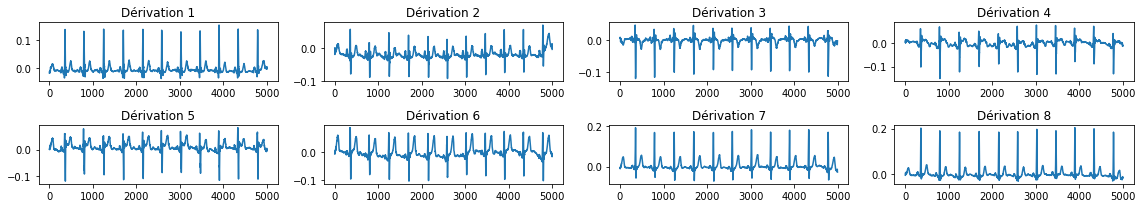

In [24]:

fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        derivation = i * 4 + j  
        ecg_signal = out_cond[0, derivation, :]
        
        axes[i, j].plot(ecg_signal)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

plt.tight_layout()
plt.show()

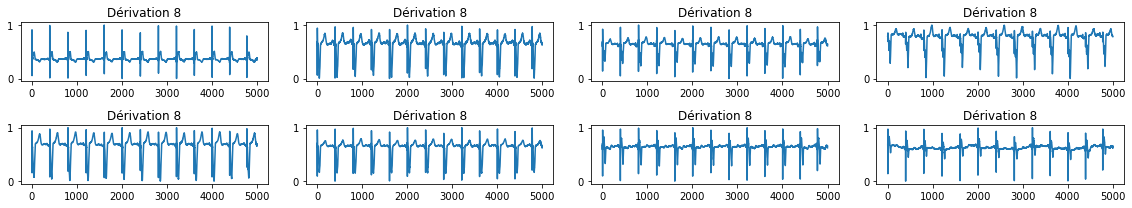

In [25]:
# Parcours des dérivations et affichage sur la grille
# Création de la grille de sous-graphiques

fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        d = i * 4 + j  # Numéro de la dérivation
        ecg_real = pkt_ecg[5, d, :]  # Premier ECG de la dérivation spécifique
        
        axes[i, j].plot(ecg_real)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

# Réglages d'affichage des sous-graphiques
plt.tight_layout()
plt.show()

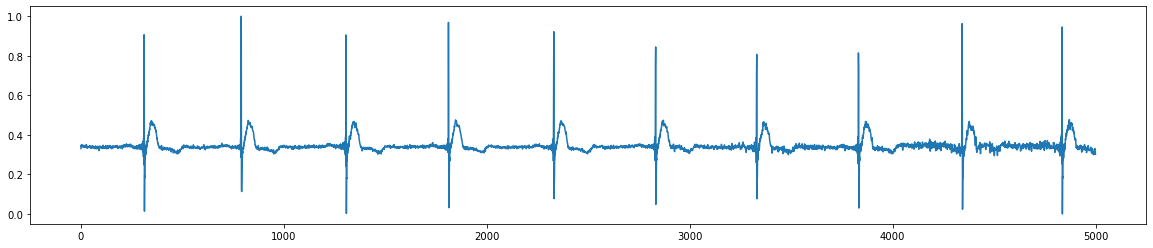

In [26]:
ecg = pkt_ecg[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(ecg);

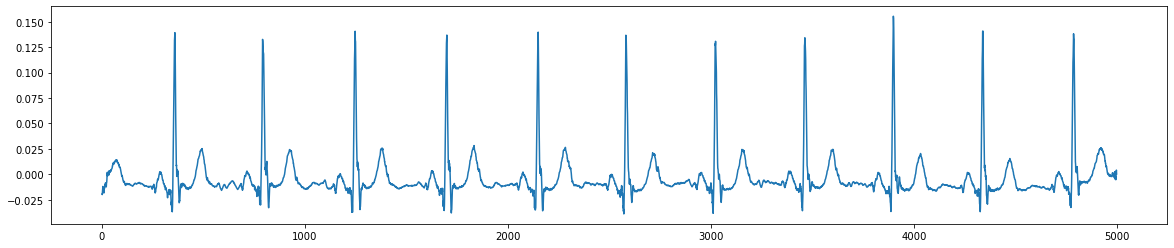

In [27]:
fake_ecg = out_cond[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(fake_ecg);

In [28]:
def normalize_ecg_data(ecg_data):
    
    normalized_data = np.zeros_like(ecg_data, dtype=float)
    
    for i in range(ecg_data.shape[0]):
        for j in range(ecg_data.shape[1]):
            derivation = ecg_data[i, j, :]
            max_val = np.max(derivation)
            min_val = np.min(derivation)
            normalized_data[i, j, :] = (derivation - min_val) / (max_val - min_val)
    
    return normalized_data

In [29]:
fake_norm = normalize_ecg_data(out_cond)

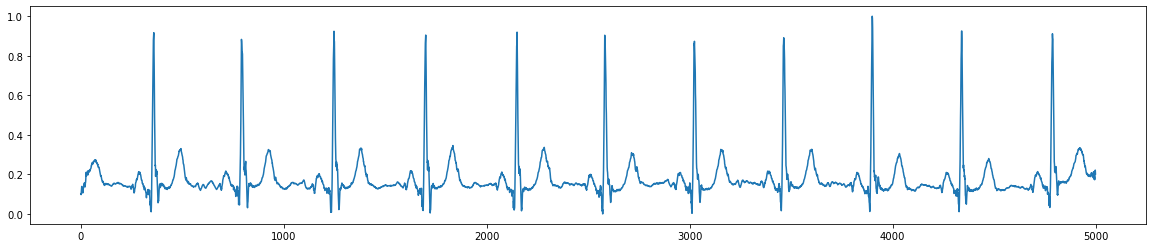

In [30]:

sample_fake_norm = fake_norm[0, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(sample_fake_norm);

In [31]:
print(pkt_ecg.shape)#(52, 8, 5000)
print(fake_norm.shape)#(52, 8, 5000)
# How to compute mmd between pkt_ecg and fake_norm ?

(52, 8, 5000)
(52, 8, 5000)


In [70]:
# def kernel_matrix(data):
#     n_samples = data.shape[0]
#     pairwise_dists = pairwise_distances(data.reshape(n_samples, -1))
#     sigma = np.median(pairwise_dists)
#     kernel = np.exp(-pairwise_dists**2 / (2 * sigma**2))
#     return kernel

# def mmd(K_real, K_synthetic):
#     n = K_real.shape[0]
#     m = K_synthetic.shape[0]
#     mmd = np.sum(K_real) / (n * (n - 1)) - 2 * np.sum(K_synthetic) / (n * m) + np.sum(K_synthetic) / (m * (m - 1))
#     return mmd

In [71]:
def mmd(targets, predictions):
    mmd_stat = MMDStatistic(5000, 5000)
    sample_target = torch.from_numpy(targets.reshape((52*8, 5000)))
    sample_pred = torch.from_numpy(predictions.reshape((52*8, 5000)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.] * 5000)
    return stat.item()

In [72]:
# K_real = kernel_matrix(pkt_ecg)
# K_synthetic = kernel_matrix(fake_norm)

mmd_value = mmd(pkt_ecg, fake_norm)
print("Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels:", mmd_value)

Valeur du MMD entre les ECG générés du deep-fake et ceux qui sont réels: 0.010334639864687658


## Data Augmentation with ECG transformations

In [34]:
# The function below performs data augmentation on a given dataset.
# It takes in one input parameter:
# - data: a numpy array of shape (n_samples, n_features), where n_samples is the number 
# of samples and n_features is the number of features.

    # It returns one output parameter:
    # - augmented_data: a numpy array of shape (n_samples, n_features), where each sample 
    # in the original dataset has been randomly scaled up or down by a factor between 0.90 and 1.10.

def data_augmentation(data):
    # Create an empty list to store the augmented samples
    augmented_data = []
    
    # Get the number of samples in the dataset(52)
    n_samples = data.shape[0]
    
    ## Loop through each sample in the dataset
    for i in range(n_samples):
        
        # Get the current sample
        sample = data[i]
         # Make a copy of the current sample
        aug_sample = sample.copy()  
        # Generate random scaling factors for each feature
        delta = np.random.uniform(0.90, 1.00, size=(8, 5000)) 
        # Scale each feature by its corresponding scaling factor
        aug_sample *= delta  
        # Add the augmented sample to the list of augmented samples
        augmented_data.append(aug_sample)
        
    # Convert the list of augmented samples to a numpy array and return it
    augmented_data = np.array(augmented_data)
    return augmented_data

In [35]:
data_augmented = data_augmentation(pkt_ecg)
print(data_augmented.shape)

(52, 8, 5000)


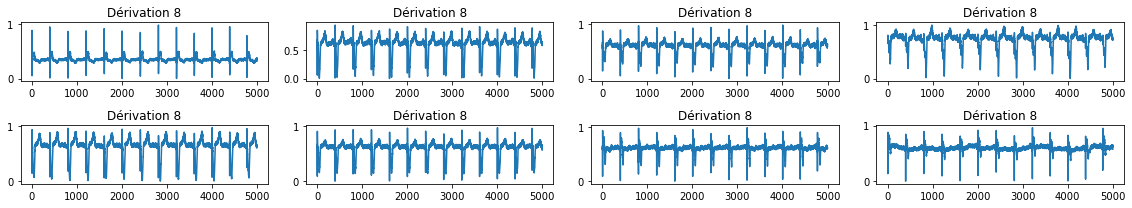

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(16, 3))
for i in range(2):
    for j in range(4):
        d = i * 4 + j  # Numéro de la dérivation
        ecg_real = data_augmented[5, d, :]  # Premier ECG de la dérivation spécifique
        
        axes[i, j].plot(ecg_real)
        axes[i, j].set_title(f"Dérivation {derivation + 1}")

# Réglages d'affichage des sous-graphiques
plt.tight_layout()
plt.show()

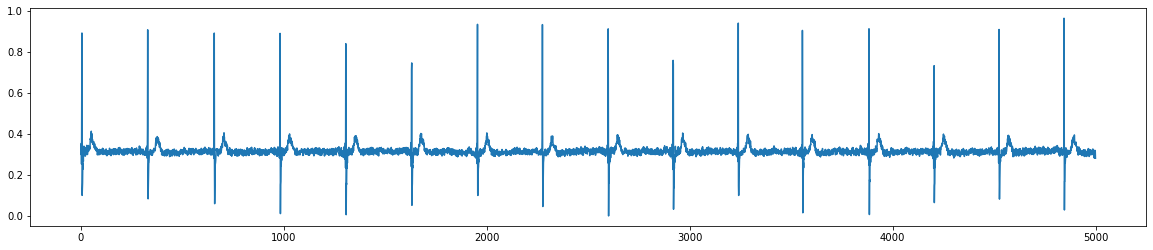

In [37]:
augmented_sample = data_augmented[1, 0, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(augmented_sample);

In [73]:
#K_augmented = kernel_matrix(data_augmented)

mmd_value_aug = mmd(pkt_ecg, data_augmented)
print("Valeur du MMD entre les ECG générés de l'augmentation de données et ceux qui sont réels:", mmd_value_aug)

Valeur du MMD entre les ECG générés de l'augmentation de données et ceux qui sont réels: 0.013697743464741952


In [74]:

df = pd.DataFrame({'Méthodes d\'augmentations': ['DeepFake using GAN vs Real ECG Evaluation', 'Random Factors Multiplied vs Real ECG Evaluation'], 'Valeur MMD': [mmd_value, mmd_value_aug]})
print(df.to_string(index=False))

                        Méthodes d'augmentations  Valeur MMD
       DeepFake using GAN vs Real ECG Evaluation    0.010335
Random Factors Multiplied vs Real ECG Evaluation    0.013698


## Calcul des autres dérivations manquantes : 
- **lead III value** = (lead II value) - (lead I value)
- **lead aVR value** = -0.5*(lead I value + lead II value)
- **lead aVL value** = lead I value - 0.5 * lead II value
- **lead aVF value** = lead II value - 0.5 * lead I value


In [40]:
# ["lead_1", "lead_2", "lead_3", "lead_avr", "lead_avl", "lead_avf","lead_v1", "lead_v2", "lead_v3", "lead_v4", "lead_v5", "lead_v6"]

def retrieve_derivations(data_preprocessed):
    n_samples, n_existing_derivations, n_points = data_preprocessed.shape
    n_new_derivations = 4  # Nombre de nouvelles dérivations à retrouver
    
    # Créez un tableau vide pour stocker les nouvelles dérivations
    data_full = np.zeros((n_samples, n_existing_derivations + n_new_derivations, n_points))
    
    # Copiez les dérivations existantes dans le nouvel ensemble de données
    data_full[:, :n_existing_derivations, :] = data_preprocessed
    
    # Retrouvez les nouvelles dérivations en utilisant les formules fournies
    data_full[:, n_existing_derivations, :] = data_full[:, 1, :] - data_full[:, 0, :]  # lead_3
    data_full[:, n_existing_derivations + 1, :] = -0.5 * (data_full[:, 0, :] + data_full[:, 1, :])  # lead_avr
    data_full[:, n_existing_derivations + 2, :] = data_full[:, 0, :] - 0.5 * data_full[:, 1, :]  # lead_avl
    data_full[:, n_existing_derivations + 3, :] = data_full[:, 1, :] - 0.5 * data_full[:, 0, :]  # lead_avf
    
    # Réorganisez les dérivations pour correspondre à l'ordre souhaité
    order = ["lead_1", "lead_2", "lead_3", "lead_avr", "lead_avl", "lead_avf", "lead_v1", "lead_v2", "lead_v3", "lead_v4", "lead_v5", "lead_v6"]
    data_full_reordered = np.zeros((n_samples, n_existing_derivations + n_new_derivations, n_points))
    for i, deriv_name in enumerate(order):
        deriv_index = order.index(deriv_name)
        data_full_reordered[:, i, :] = data_full[:, deriv_index, :]
    
    return data_full_reordered

In [41]:
fakes_recover = retrieve_derivations(fake_norm)
print(fakes_recover.shape)

(52, 12, 5000)


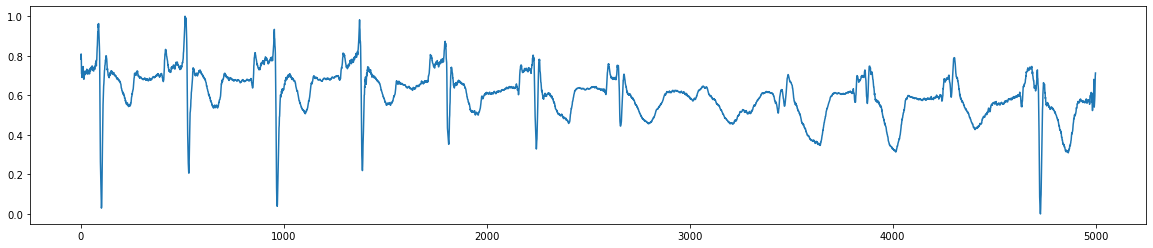

In [42]:
recover_fakes_sample = fakes_recover[1, 2, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(recover_fakes_sample);

In [43]:
fakes_aug_recover = retrieve_derivations(data_augmented)
print(fakes_aug_recover.shape)

(52, 12, 5000)


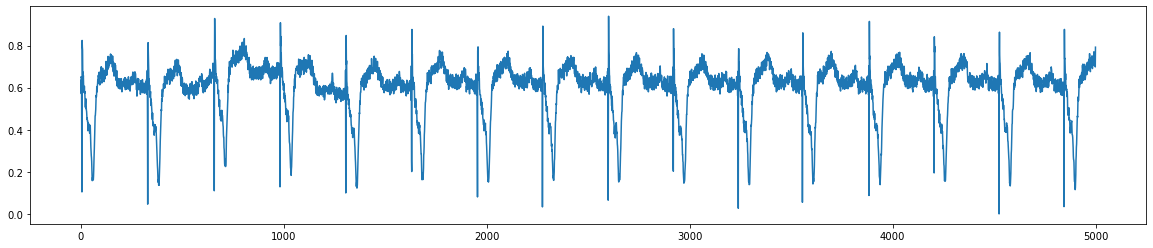

In [44]:
recover_aug_sample = fakes_aug_recover[1, 2, :]
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(recover_aug_sample);

## Évaluation du MMD sur l'ensemble de données finales (Avec les 12 dérivations)

In [45]:
# Chargement des données HDF5
with h5py.File('xml_data/dataset/FinalTracings.h5', 'r') as hf:
    data = hf['tracings'][:]

data.shape

(52, 4096, 12)

In [46]:
def resample_data(data, new_length):
    n_samples, n_channels, n_points = data.shape
    
    # Créer un tableau vide pour stocker les données rééchantillonnées
    resampled_data = np.zeros((n_samples, n_channels, new_length))
    
    # Rééchantillonner chaque échantillon et chaque canal individuellement
    for i in range(n_samples):
        for j in range(n_channels):
            resampled_data[i, j, :] = resample(data[i, j, :], new_length)
    
    return resampled_data

In [47]:
fakes_recover = resample_data(fakes_recover, 4096)
fakes_aug_recover = resample_data(fakes_aug_recover, 4096)

print(fakes_recover.shape)
print(fakes_aug_recover.shape)

(52, 12, 4096)
(52, 12, 4096)


In [75]:
def mmd_final(targets, predictions):
    mmd_stat = MMDStatistic(4096, 4096)
    sample_target = torch.from_numpy(targets.reshape((52*12, 4096)))
    sample_pred = torch.from_numpy(predictions.reshape((52*12, 4096)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.] * 4096)
    return stat.item()


In [76]:
mmd_modified_df = mmd_final(data, fakes_recover)
mmd_modified_af = mmd_final(data, fakes_aug_recover)

In [77]:
df_final_modified = pd.DataFrame({'Méthodes d\'augmentations': ['DeepFake using GAN vs Real ECG Evaluation', 'Random Factors Multiplied vs Real ECG Evaluation'], 'Valeur MMD': [mmd_modified_df, mmd_modified_af]})
print(df_final_modified.to_string(index=False))

                        Méthodes d'augmentations  Valeur MMD
       DeepFake using GAN vs Real ECG Evaluation    0.000930
Random Factors Multiplied vs Real ECG Evaluation    0.003129


,Méthodes d'augmentations,Valeur MMD
0,DeepFake using GAN vs Real ECG Evaluation,0.000930
1,Random Factors Multiplied vs Real ECG Evaluation,0.003129


In [81]:
final_deep_fakes_recover = np.transpose(fakes_recover, (0, 2, 1))
print(final_deep_fakes_recover.shape)

(52, 4096, 12)


In [82]:
with h5py.File('xml_data/dataset/Fakes_ECG.h5', 'w') as f:
    f.create_dataset('tracings', data=final_deep_fakes_recover)